In [5]:
import tomopy
import math
import svmbir
import dxchange
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import bm3d_streak_removal as bm3d_rmv
from imars3dv2.filters import tilt #I have imported tilt from iMars3D (neutron imaging repository by ORNL)

In [6]:
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp

In [7]:
# %matplotlib notebook
%matplotlib inline

In [8]:
def get_ind_list(name_list:list):
    ind = []
    ang_deg = []
    ang_rad = []
    ind_dict_random = {}
    ind_dict_sorted = {}
    for e_name in name_list:
        _split = e_name.split('_')
        _index_tiff = _split[-1]
        _index = _index_tiff.split('.')[0]
        _ang = _split[-3] + '.' + _split[-2]
        index = int(_index)
        angle = float(_ang)
        ind.append(index)
        ang_deg.append(angle)
        ang_rad.append(math.radians(angle))
        ind_dict_random[index] = e_name
    ind = sorted(ind)
    for n, e_ind in enumerate(ind):
        ind_dict_sorted[n] = ind_dict_random[e_ind]
    
    return list(ind_dict_sorted.values()), (sorted(ang_deg)), np.array(sorted(ang_rad)), ind

def get_list(name_list:list):
    ind = []
    ind_dict_random = {}
    ind_dict_sorted = {}
    for e_name in name_list:
        _split = e_name.split('_')
        _index_tiff = _split[-1]
        _index = _index_tiff.split('.')[0]
        index = int(_index)
        ind.append(index)
        ind_dict_random[index] = e_name
    ind = sorted(ind)
    for n, e_ind in enumerate(ind):
        ind_dict_sorted[n] = ind_dict_random[e_ind]
    
    return list(ind_dict_sorted.values()), ind

def _init_arr_from_stack(fname, number_of_files, slc=None):
    """
    Initialize numpy array from files in a folder.
    """
    _arr = dxchange.read_tiff(fname, slc)
    size = (number_of_files, _arr.shape[0], _arr.shape[1])
    return np.empty(size, dtype=_arr.dtype)

def read_tiff_stack(fdir, fname:list):
    arr = _init_arr_from_stack(os.path.join(fdir, fname[0]), len(fname))
    for m, name in enumerate(fname):
        arr[m] = dxchange.read_tiff(os.path.join(fdir, name))
    return arr

def find_proj180_ind(ang_list:list):
    dif = [abs(x-180) for x in ang_list]
    difmin = min(dif)
    ind180 = dif.index(difmin)
    return (ind180, ang_list[ind180])

def shrink_window(corners, size):
    corners[0][0] = corners[0][0] + size
    corners[0][1] = corners[0][1] + size
    corners[1][0] = corners[1][0] + size
    corners[1][1] = corners[1][1] - size
    corners[2][0] = corners[2][0] - size
    corners[2][1] = corners[2][1] - size
    corners[3][0] = corners[3][0] - size
    corners[3][1] = corners[3][1] + size
    return corners

def set_roi(corners, xmin, ymin, xmax, ymax):
    corners[0][0] = xmin
    corners[0][1] = ymin
    corners[1][0] = xmin
    corners[1][1] = ymax
    corners[2][0] = xmax
    corners[2][1] = ymax
    corners[3][0] = xmax
    corners[3][1] = ymin
    return corners

In [9]:
###################### need to change start
ipts="27158" #this is the name of the folder I have my data in.
###################### need to change end

# Load CT files

Found index of 180 degree projections:  313
Loading CT projections...
(585, 2048, 2048)


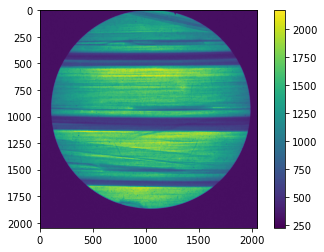

In [10]:
###################### need to change start
ct_scan_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/PSI 3D data/N_char/Weighed averaged"
###################### need to change end
ct_list = glob.glob(ct_scan_loc+'/img*')
ct_name, ind_list = get_list(ct_list)
theta = tomopy.angles(len(ind_list), ang1=0, ang2=336.384)
ang_deg = np.rad2deg(theta)
proj180_ind = find_proj180_ind(ang_deg)[0] 
print('Found index of 180 degree projections: ', proj180_ind)
print('Loading CT projections...')
proj = read_tiff_stack(fdir=ct_scan_loc, fname=ct_name)
print(proj.shape)
plt.imshow(proj[0])
plt.colorbar()
plt.show()

# Load Open Beam (OB)

Loading Open Beam (OB)...
(1, 2048, 2048)


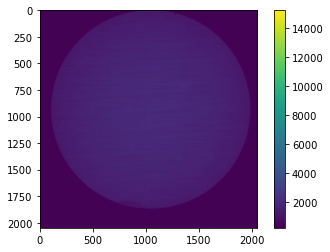

In [11]:
ob_list = glob.glob(ct_scan_loc+'/MED_Ndisc_OB*')
ob_name, ob_ind_list = get_list(ob_list)
print("Loading Open Beam (OB)...")
ob = read_tiff_stack(fdir=ct_scan_loc, fname=ob_name)
print(ob.shape)
plt.imshow(ob[0])
plt.colorbar()
plt.show()

# Load Dark Current (DC)

Loading Dark Current (DC)...
(1, 2048, 2048)


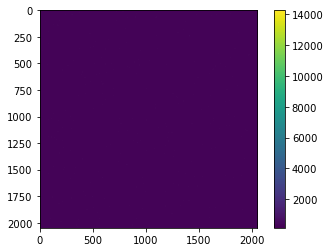

In [12]:
dc_list = glob.glob(ct_scan_loc+'/MED_Nchar_DC*')
dc_name, dc_ind_list = get_list(dc_list)
print("Loading Dark Current (DC)...")
dc = read_tiff_stack(fdir=ct_scan_loc, fname=dc_name)
print(dc.shape)
plt.imshow(dc[0])
plt.colorbar()
plt.show()

# Detect and crop the slits

Projection at 0 degree:


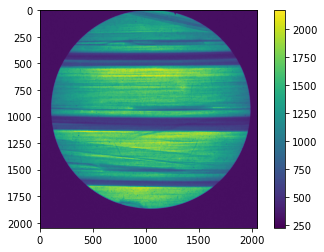

Projection at 180 degree:


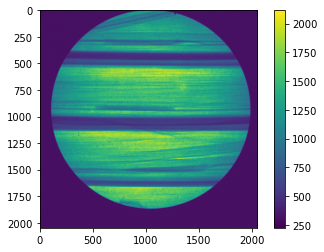

In [13]:
slit_box_corners = tomopy.prep.alignment.find_slits_corners_aps_1id(img=ob[0], method='simple')
# print("Slit corners: ", slit_box_corners)
# proj = tomopy.prep.alignment.remove_slits_aps_1id(proj, slit_box_corners)
# ob = tomopy.prep.alignment.remove_slits_aps_1id(ob, slit_box_corners)
# dc = tomopy.prep.alignment.remove_slits_aps_1id(dc, slit_box_corners)
print("Projection at 0 degree:")
plt.imshow(proj[0])
plt.colorbar()
plt.show()
print("Projection at 180 degree:")
plt.imshow(proj[proj180_ind])
plt.colorbar()
plt.show()

# Define the ROI

Projection at 0 degree:


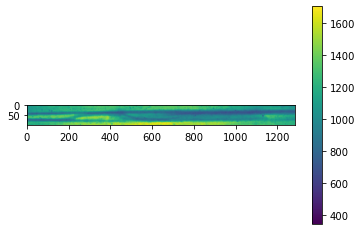

Projection at X degree:


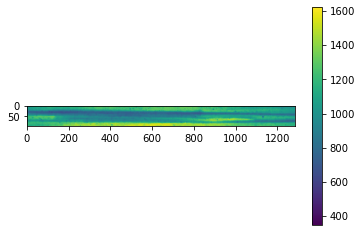

Projection at 180 degree:


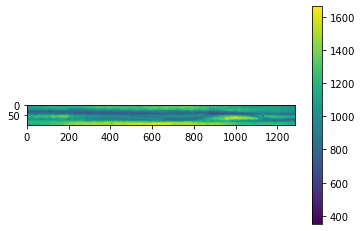

In [14]:
roi_corners = set_roi(corners=slit_box_corners, xmin = 400, ymin=250, xmax=1695, ymax=360)
proj_crop = tomopy.prep.alignment.remove_slits_aps_1id(proj, roi_corners)
ob_crop = tomopy.prep.alignment.remove_slits_aps_1id(ob, roi_corners)
dc_crop = tomopy.prep.alignment.remove_slits_aps_1id(dc, roi_corners)
print("Projection at 0 degree:")
plt.imshow(proj_crop[0])
plt.colorbar()
plt.show()
print("Projection at X degree:")
plt.imshow(proj_crop[234])
plt.colorbar()
plt.show()
print("Projection at 180 degree:")
plt.imshow(proj_crop[proj180_ind])
plt.colorbar()
plt.show()

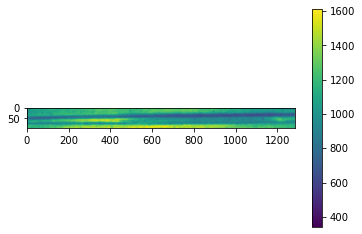

In [15]:
plt.imshow(proj_crop[579])
plt.colorbar()
plt.show()

Projection at 0 degree:


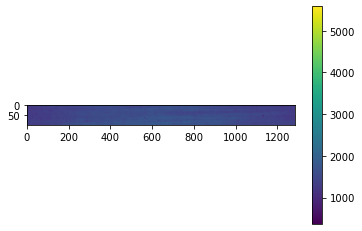

Projection at 180 degree:


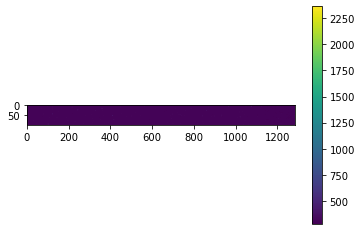

In [16]:
print("Projection at 0 degree:")
plt.imshow(ob_crop[0])
plt.colorbar()
plt.show()
print("Projection at 180 degree:")
plt.imshow(dc_crop[0])
plt.colorbar()
plt.show()

# Normalization

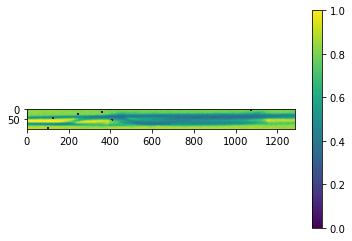

In [17]:
proj_norm = tomopy.normalize(proj_crop, ob_crop, dc_crop)
plt.imshow(proj_norm[0], vmax=1, vmin=0)
plt.colorbar()
plt.show()

# Filter NaN and negative

In [18]:
proj_norm = tomopy.remove_nan(proj_norm)
proj_norm = tomopy.remove_neg(proj_norm)

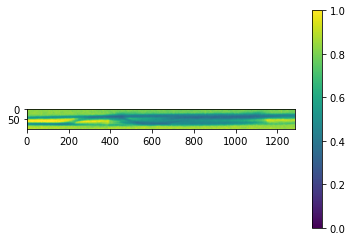

In [19]:
plt.imshow(proj_norm[0], vmax=1, vmin=0)
plt.colorbar()
plt.show()

# Minus log conversion

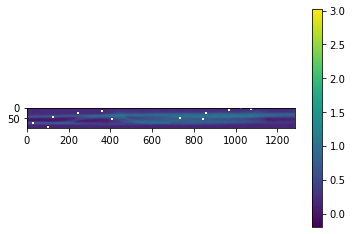

In [20]:
proj_mlog = tomopy.minus_log(proj_norm)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()

# Remove Outliers

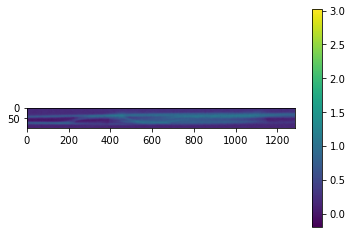

In [22]:
proj_mlog_filter = tomopy.remove_outlier(proj_mlog, 50)
plt.imshow(proj_mlog_filter[0])
plt.colorbar()
plt.show()

# Ring Artifact Removal

Before ring removal:


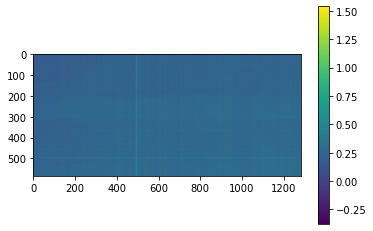

After ring removal:


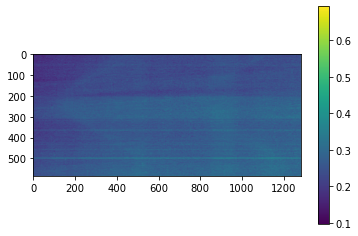

In [23]:
#Vo filter_AllStripe:
proj_rmv = tomopy.prep.stripe.remove_all_stripe(proj_mlog_filter, snr=1, la_size=70, sm_size=60, dim=1, ncore=None, nchunk=None)

print("Before ring removal:")
plt.imshow(proj_mlog_filter[:, 5, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_rmv[:, 5, :])
plt.colorbar()
plt.show()

# Find and correct tilt

Finding the tilt angle...
Found the tilt angle:  -0.08539278362050456


Applying tilt corr:   0%|          | 0/585 [00:00<?, ?it/s]

Projection at 0 degree:


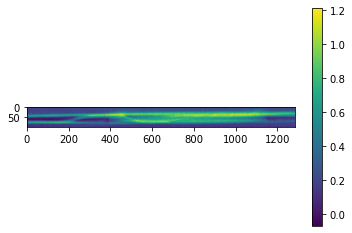

Projection at 180 degree:


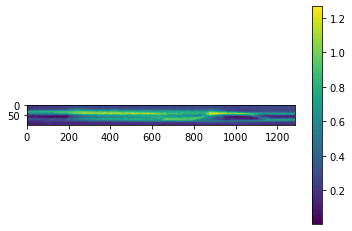

In [24]:
print("Finding the tilt angle...")
tilt_ang = tilt.calculate_tilt(image0=proj_rmv[0], image180=proj_rmv[proj180_ind])
#tilt_ang.x = -0.1
print("Found the tilt angle: ", tilt_ang.x)
proj_tilt = tilt.apply_tilt_correction(proj_rmv, tilt_ang.x)
print("Projection at 0 degree:")
plt.imshow(proj_tilt[0])
plt.colorbar()
plt.show()
print("Projection at 180 degree:")
plt.imshow(proj_tilt[proj180_ind])
plt.colorbar()
plt.show()

# Find Center of Rotation in sinogram space

In [25]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_tilt[0,:,:]), np.squeeze(proj_tilt[proj180_ind,:,:]), tol=0.5)
print('Estimated center of rotation: ', rot_center)
rot_center = rot_center + 18 # this gives an ROI estimate only.

Estimated center of rotation:  641.5


# Reconstruction

In [26]:
rot_center=670
recon = rec.fbp_reconstruction(proj_tilt, rot_center, angles=theta, ratio=None, ramp_win=None, filter_name="hamming", pad=None, pad_mode='symmetric', apply_log=False, gpu=True, block=(16, 16), ncore=None)

/SNS/users/myusuf/.local/lib/python3.8/site-packages/algotom/rec/reconstruction.py:375: UserWarning: !!!No Nvidia GPU found!!!Run with CPU instead!!!
  warnings.warn("!!!No Nvidia GPU found!!!Run with CPU instead!!!")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


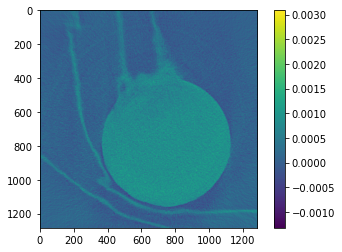

In [27]:
b = np.zeros((recon.shape[1], recon.shape[0], recon.shape[2]))
A = (recon.shape[1])
for i in range (0,A):
    a = recon[:,i,:]
    b[i,:,:] = a
    
plt.imshow(b[60, :, :])
plt.colorbar()
plt.show()

# Export recon files

In [32]:
for i in range (0,A):
    Num = str(i)
    B = b[i,:,:]
    losa.save_image("/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/Maha/04-12-2023-PSI/AllStripeOpt/Hamming(sym)/Top_char/Top_char_"+Num+".tiff",B)